In [1]:
import numpy as np
import scipy.stats as sps

import matplotlib.pyplot as plt
%matplotlib inline
# plt.rcParams['figure.figsize'] = [2, 1]

In [2]:
from sklearn import datasets
from distr_tools import mixture_dist,mv_iid_dist

Plotting Parameters

In [3]:
fsize = 4.
folder = '../fig/'

Helper Functions

In [4]:
from scipy.optimize import fsolve

# compute for Gaussian Kernel 1D
RK = 1/(2*np.sqrt(np.pi))
mu2K = 1

def compute_alpha2_factor(x):
    # 6th and 4th derivative of standard normal distribution
    phi6 = lambda x: (x ** 6 - 15 * x ** 4 + 45 * x ** 2 - 15) * sps.norm.pdf(x)
    phi4 = lambda x: (x ** 4 - 6 * x ** 2 + 3) * sps.norm.pdf(x)
    
    # differences and data params
    n = len(x)
    diff_matrix = np.tile(x,(n,1))-np.tile(x,(n,1)).T # xi-xj for double dum
    lam_iqr = sps.iqr(x)

    # constants
    a = 0.920*lam_iqr*n**(-1./7)
    b = 0.912*lam_iqr*n**(-1./9)

    # compute denominator
    Tdb = np.sum(phi6(diff_matrix/b))
    Tdb /= -(n*(n-1)*b**7)

    # compute numerator
    Sda = np.sum(phi4(diff_matrix/a))
    Sda /= (n*(n-1)*a**5)

    return 1.357*(Sda/Tdb)**(1./7)

def js_eq12(x,h,alpha2_factor=None, RK=RK, SK=mu2K):
    # 6th and 4th derivative of standard normal distribution
    phi6 = lambda x: (x ** 6 - 15 * x ** 4 + 45 * x ** 2 - 15) * sps.norm.pdf(x)
    phi4 = lambda x: (x ** 4 - 6 * x ** 2 + 3) * sps.norm.pdf(x)
    
    # differences and data params
    n = len(x)
    diff_matrix = np.tile(x,(n,1))-np.tile(x,(n,1)).T # xi-xj for double dum
    
    # alpha2 factor
    if alpha2_factor is None:
        alpha2 = compute_alpha2_factor(x)
    else:
        alpha2 = alpha2_factor
        
    # compute Sd(alpha2(h))
    alpha2h = alpha2*h**(5./7)
    Sdalpha2h = np.sum(phi4(diff_matrix/alpha2h))
    Sdalpha2h /= (n*(n-1)*alpha2h**5)
    
    # eq. 12 from Sheather and Jones (1991) paper: goal is to find the zero
    output = (RK/(SK**2*Sdalpha2h))**(1./5)*n**(-1./5)-h
    
    return output
         

## Problem Setup

Suppose our model of interest is the following map from $\mathbb{R}^4\rightarrow\mathbb{R}^2$:

\begin{align}
Q(r,\theta,c_x,c_y)=\begin{bmatrix}r\cos\theta \\ r\sin\theta \end{bmatrix} + \begin{bmatrix} c_x \\ c_y \end{bmatrix}
\end{align}

This model creates circles of radius $r$ around centers $c:=(c_x,c_y)$.

In [5]:
def Q(lam):
    r,th,xeps,yeps = lam.T
    return np.stack([r*np.cos(th)+xeps,r*np.sin(th)+yeps]).T

For this example, we suppose that we have prior knowledge of three potential centers for the circle,

$$\left\{c_1,c_2,c_3\right\}=\left\{(-1,0.5),(0,0),(1,0.5)\right\}$$

but there is some uncertainty in these locations. To be specific, we assume that

\begin{align}
c\sim \sum_{k=1}^Kw_k N(c_k,\Sigma),
\end{align}

i.e., a Gaussian mixture model where $\Sigma=\sigma^2 I$ represents the uncertainty in the locations $c_k$ and $w_k$ are initial probability weights for each circle.

Our initial assumptions for the distribution of radii and angle sweep are $r\sim U[0.75,1.25]$ and $\theta\sim U[0,2\pi]$.

In [6]:
class custom_init_pdf:
    '''
    Defines the custom initial pdf for this example
    '''
    def __init__(self,r_dist,th_dist,cxy_dist):
        self.r_dist = r_dist
        self.th_dist = th_dist
        self.cxy_dist = cxy_dist
    
    def logpdf(self,r_th_cxy):
        ''' Computes log pdf '''
        r,th,cx,cy = r_th_cxy.T
        cxy = np.column_stack([cx,cy])
        out = self.r_dist.logpdf(r)+self.th_dist.logpdf(th)
        out += self.cxy_dist.logpdf(cxy)
        return out
    
    def pdf(self,r_th_cxy):
        ''' Computes pdf '''
        return np.exp(self.logpdf(r_th_cxy))
    
    def rvs(self,size=1,random_state=None):
        ''' Generates random initial sample '''
        if (random_state == None) or (type(random_state)==int):
            rng = np.random.default_rng(random_state)
        elif type(random_state)==np.random.Generator:
            rng = random_state
        else:
            raise ValueError ('random_state must be an integer or numpy.random.Generator object.')            
        out = np.column_stack([dist.rvs(size,random_state=rng) for dist in [self.r_dist,self.th_dist,self.cxy_dist]])
        return out
        

In [7]:
# initial distributions
r_init = sps.uniform(0.75,0.5)
th_init = sps.uniform(0,2*np.pi)

# center locations and distribution
init_center = [np.zeros(2),np.array([1,0.5]),np.array([-1,0.5])]
center_init = mixture_dist([sps.multivariate_normal(mu,0.005*np.eye(2)) for mu in init_center],
                           np.ones(len(init_center))/len(init_center),multi=True)

# define the initial distribution
init_dist = custom_init_pdf(r_init,th_init,center_init)

In [8]:
# initial sample
rng = np.random.default_rng(523230125)
n_init = 5000
init_sample = init_dist.rvs(n_init)

# plotting visualization values
lam_dict = {'r': np.linspace(r_init.support()[0]-0.25,r_init.support()[1]+0.25,250),
            'th': np.linspace(th_init.support()[0]-0.25,th_init.support()[1]+0.25,250)}
cx,cy = [np.linspace(-1.5,1.5,150+i) for i in range(2)]
Cx,Cy = np.meshgrid(cx,cy)
Cxy_eval = np.stack([Cx.reshape(-1,),Cy.reshape(-1,)],axis=-1)
lam_dict['c'] = (Cx,Cy,Cxy_eval)



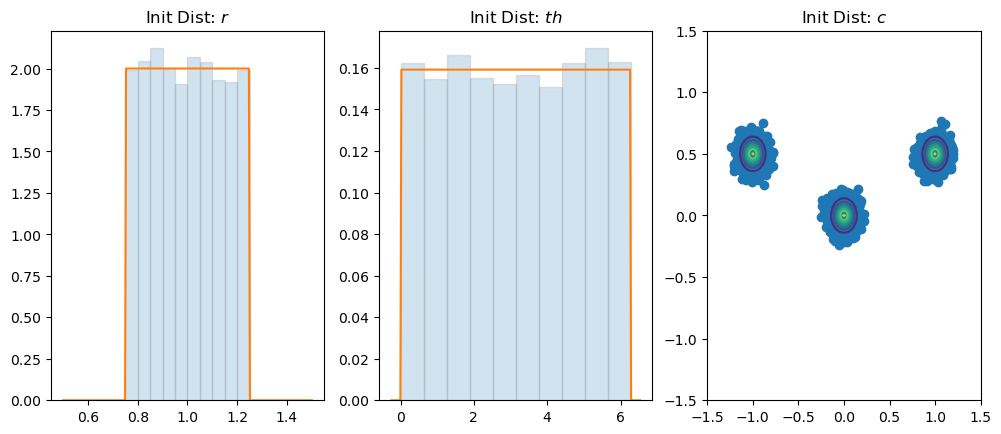

In [9]:
# plot check initial distributions
fig, axes = plt.subplots(1,3)
fig.set_figwidth(4*3)
for i,(key,ax) in enumerate(zip(lam_dict.keys(),axes)):
    if key=='c':
        X,Y,XY_eval = lam_dict[key]
        this_probs = init_dist.cxy_dist.pdf(XY_eval).reshape(X.shape)
        ax.scatter(init_sample[:,-2],init_sample[:,-1])
        ax.contour(X,Y,this_probs)
    else:
        ax.hist(init_sample[:,i],density=True,edgecolor='gray',alpha=0.2)
        this_x = lam_dict[key]
        ax.plot(this_x,[init_dist.r_dist,init_dist.th_dist][i].pdf(this_x))
    
    ax.set_title('Init Dist: ${}$'.format(key))

These initial distributions produce the following predicted circle values.

In [10]:
# compute predicted sample
pred_sample = Q(init_sample)

# plot values for data space
qx,qy = [np.linspace(-2.5,2.5,150),np.linspace(-1.5,2,151)]
Qx,Qy = np.meshgrid(qx,qy)
Qxy_eval = np.stack([Qx.reshape(-1,),Qy.reshape(-1,)],axis=-1)

Text(0.5, 1.0, 'Pred Sample')

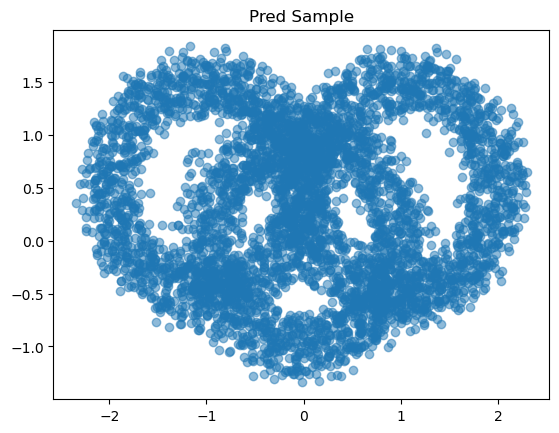

In [11]:
# plot check predicted sample
plt.scatter(*pred_sample.T,alpha=0.5)
plt.title("Pred Sample")

Suppose we observe data from the "dual moons" dataset. We want to find an updated distribution of radii, angles, and centers which is consistent with this observed distribution.

In [12]:
# sample observed distribution
n_obs = 500
moon_noise = 0.05
obs_sample,moon_classes = datasets.make_moons(n_samples=n_obs,noise=moon_noise,random_state=5743203)

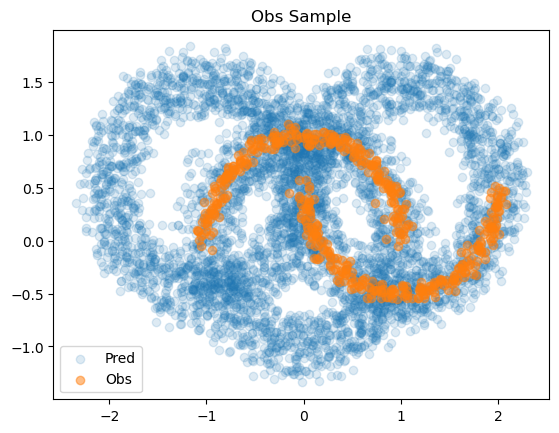

In [13]:
# plot check predictability assumption
plt.title("Obs Sample")
plt.scatter(*pred_sample.T,alpha=0.15,label='Pred')
plt.scatter(*obs_sample.T,alpha=0.5,label='Obs')
plt.legend()

### Nice Figure

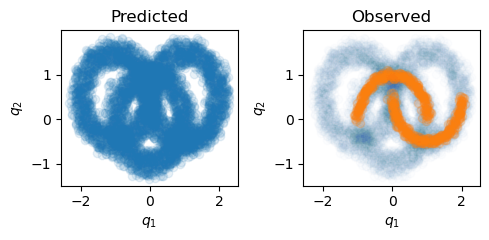

In [14]:
ex_setup_fig, (ax1,ax2) = plt.subplots(1,2)
ex_setup_fig.set_figwidth(5)
ex_setup_fig.set_figheight(2.5)

for i,ax in enumerate([ax1,ax2]):
    ax.scatter(*pred_sample.T,label='Pred',alpha=[0.1,0.01][i])
    ax.set_title(['Predicted','Observed'][i])
    ax.set_xlabel('$q_1$')
    ax.set_ylabel('$q_2$')
    
ax2.scatter(*obs_sample.T,label='Obs',alpha=0.2)
ex_setup_fig.tight_layout()
ex_setup_fig

name_kLmmd_fig = 'kLmmd_fig_setup'
# ex_setup_fig.savefig(folder+name_kLmmd_fig)

# Scikit-Learn KDE to Approximate Distributions

In this part of the example, we will use scikit-learn's KDE functions to approximate the observed and predicted distributions.

In particular, we will compare how the choice of bandwidth affects the quality of the solution and demonstrate how optimizing the bandwidth in terms of the KL-divergence leads to a better quality result.

In [15]:
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from sklearn.metrics import make_scorer

from scipy.spatial.distance import cdist # for definition of MMD

sk_rand_seed = 90123122 # random seed for sklearn reproducibility

In [16]:
# for computing the maximum mean discrepancy
def my_rbf_kernel(valsA,valsB):
    gamma = 1.0/valsA.shape[1]
    K = cdist(valsA,valsB,'sqeuclidean')
    K *= -gamma
    np.exp(K,K)
    return K

def my_mmd(valsA,valsB):
    mmd = 0.
    mmd += np.mean(my_rbf_kernel(valsA,valsA))
    mmd += np.mean(my_rbf_kernel(valsB,valsB))
    mmd += -2*np.mean(my_rbf_kernel(valsA,valsB))
    return np.sqrt(mmd)

In [17]:
# find the appropriate observed bandwidths
bw_init = n_obs**(-1/(2+4))*np.std(obs_sample,axis=0).mean()
obs_kde_silver = KernelDensity(kernel='gaussian',bandwidth=bw_init)
obs_kde = KernelDensity(kernel='gaussian',bandwidth=bw_init)
obs_SS = ShuffleSplit(n_splits=10,test_size=0.2,random_state=sk_rand_seed)
bw_search = GridSearchCV(obs_kde,{'bandwidth': np.geomspace(moon_noise/2,bw_init,10)},
                        refit=False,cv=obs_SS)
bw_search.fit(obs_sample)
obs_kde.bandwidth = bw_search.best_params_['bandwidth']
print('Init. bw = ', obs_kde_silver.bandwidth)
print('Obs. bw = ', obs_kde.bandwidth)


Init. bw =  0.24192224847959928
Obs. bw =  0.041399243864024826


In [18]:
# find the appropriate predicted bandwidths
bw_init = n_init**(-1/(2+4))*np.std(pred_sample,axis=0).mean()
pred_kde = KernelDensity(kernel='gaussian',bandwidth=bw_init)
pred_SS = ShuffleSplit(n_splits=10,test_size=0.2,random_state=sk_rand_seed)
bw_search = GridSearchCV(pred_kde,{'bandwidth': np.geomspace(moon_noise,bw_init,10)},
                         refit=False,cv=pred_SS)
bw_search.fit(pred_sample)
pred_kde.bandwidth = bw_search.best_params_['bandwidth']
# pred_kde.bandwidth = bw_init
print('Pred. bw = ',pred_kde.bandwidth)


Pred. bw =  0.0696103039028195


In [19]:
# fit the models and evaluate the pdfs
obs_kde_silver.fit(obs_sample)
obs_pdf_silver = np.exp(obs_kde_silver.score_samples(Qxy_eval)).reshape(Qx.shape)

obs_kde.fit(obs_sample)
obs_pdf_kde = np.exp(obs_kde.score_samples(Qxy_eval)).reshape(Qx.shape)

pred_kde.fit(pred_sample)
pred_pdf_kde = np.exp(pred_kde.score_samples(Qxy_eval)).reshape(Qx.shape)

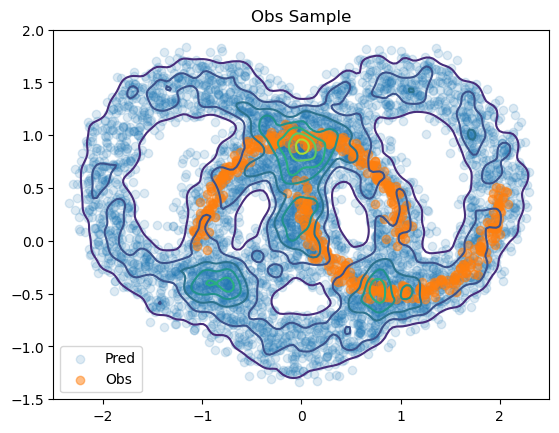

In [20]:
# plot check predictability assumption
plt.title("Obs Sample")
plt.scatter(*pred_sample.T,alpha=0.15,label='Pred')
plt.scatter(*obs_sample.T,alpha=0.5,label='Obs')
# plt.contour(Qx,Qy,obs_pdf_kde)
plt.contour(Qx,Qy,pred_pdf_kde)
plt.legend()

0.029135392074876608


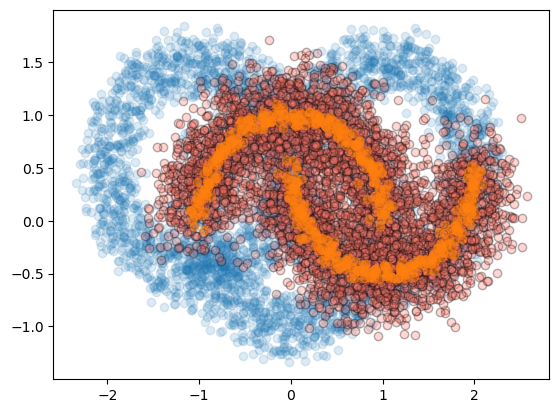

In [21]:
# compute MMD between observed and original sample
n_test = int(5e3)
obs_kde_resample = obs_kde_silver.sample(n_test)
this_mmd = my_mmd(obs_kde_resample,obs_sample)
print(this_mmd)
plt.scatter(*pred_sample.T,alpha=0.15,label='Pred')
plt.scatter(*obs_kde_resample.T,color='xkcd:salmon',alpha=0.3,edgecolor='k')
plt.scatter(*obs_sample.T,alpha=0.5,label='Obs')


0.011341906859932636


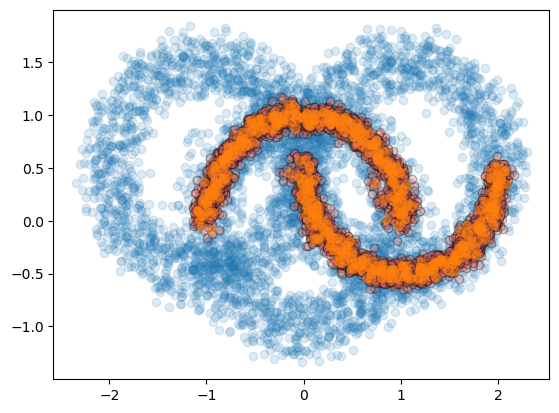

In [22]:
# compute MMD between observed and original sample
n_test = int(5e3)
obs_kde_resample = obs_kde.sample(n_test)
this_mmd = my_mmd(obs_kde_resample,obs_sample)
print(this_mmd)
plt.scatter(*pred_sample.T,alpha=0.15,label='Pred')
plt.scatter(*obs_kde_resample.T,color='xkcd:salmon',alpha=0.3,edgecolor='k')
plt.scatter(*obs_sample.T,alpha=0.5,label='Obs')



0.00964925688255214


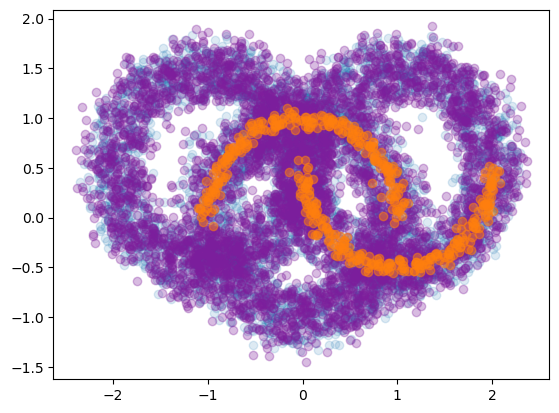

In [23]:
n_test = int(5e3)
pred_kde_resample = pred_kde.sample(n_test)
this_mmd = my_mmd(pred_kde_resample,pred_sample)
print(this_mmd)
plt.scatter(*pred_sample.T,alpha=0.15,label='Pred')
plt.scatter(*pred_kde_resample.T,color='xkcd:purple',alpha=0.3)
plt.scatter(*obs_sample.T,alpha=0.5,label='Obs')


### Updated Densities

In [24]:
r_silver = np.exp(obs_kde_silver.score_samples(pred_sample))/np.exp(pred_kde.score_samples(pred_sample))
r_cross = np.exp(obs_kde.score_samples(pred_sample))/np.exp(pred_kde.score_samples(pred_sample))

In [25]:
print(r_silver.mean())
print(r_cross.mean())

0.8969722661572826
1.0032492725378626


In [26]:
# compute an updated sample
update_dict = {}

for item in ['sr','cv']:
    # accept-reject
    this_r = r_silver if item=='sr' else r_cross
    M = np.max(this_r)
    t = rng.uniform(0,1,pred_sample.shape[0])
    accept_reject = np.less_equal(t,this_r/M)
    print('Accepted: ',np.sum(accept_reject))
    print('Accept ratio: ',np.sum(accept_reject)/len(accept_reject))

    update_dict[item] = init_sample[accept_reject,:]

Accepted:  624
Accept ratio:  0.1248
Accepted:  272
Accept ratio:  0.0544


In [27]:
# sheather-jones bandwidths
h_sj_dict = {'r': {'sr': None, 'cv': None},
             'th': {'sr': None, 'cv': None}}
for i,p in enumerate(h_sj_dict.keys()):
    for item in h_sj_dict[p].keys():
        this_sample = update_dict[item][:,i]

        # compute constant factor from data
        a2_fact = compute_alpha2_factor(this_sample)
        h_init = np.std(this_sample,ddof=1)*(3/4*len(this_sample))**(-1./5) # silverman's rule

        # solve for the zero
        result = fsolve(lambda h: js_eq12(this_sample,h,alpha2_factor=a2_fact),
                        x0 = h_init)

        # put float at end of list
        h_sj_dict[p][item] = float(result)/np.std(this_sample,ddof=1)

# Sklearn GMM Model


The GMM with 10 components also uses maximum likelihood (or minimizing the KL-divergence) to fit the distribution.

In [28]:
from sklearn.mixture import GaussianMixture

In [29]:
# GMM model
obs_GMM = GaussianMixture(n_components=10,random_state=sk_rand_seed)

# fit model
obs_GMM.fit(obs_sample)

GaussianMixture(n_components=10, random_state=90123122)

In [30]:
obs_pdf_GMM = np.exp(obs_GMM.score_samples(Qxy_eval)).reshape(Qx.shape)

In [31]:
# # plot check predictability assumption
# plt.title("Obs Sample")
# plt.scatter(*pred_sample.T,alpha=0.15,label='Pred')
# plt.scatter(*obs_sample.T,alpha=0.5,label='Obs')
# # plt.contour(Qx,Qy,obs_pdf_kde)
# plt.contour(Qx,Qy,obs_pdf_GMM)
# plt.legend()

### KDE Nice Figure

In [32]:
from matplotlib import ticker

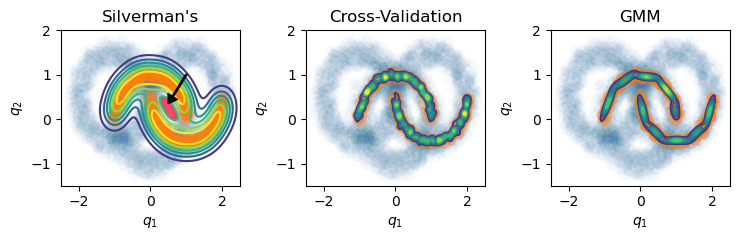

In [33]:
ex_obsKDE_fig, (ax1,ax2,ax3) = plt.subplots(1,3)
ex_obsKDE_fig.set_figwidth(7.5)
ex_obsKDE_fig.set_figheight(2.5)

for i,ax in enumerate([ax1,ax2,ax3]):
    ax.scatter(*pred_sample.T,label='Pred',alpha=0.01)
    ax.set_title(['Silverman\'s','Cross-Validation','GMM'][i])
    ax.set_xlabel('$q_1$')
    ax.set_ylabel('$q_2$')
    ax.scatter(*obs_sample.T,label='Obs',alpha=0.2)
    conts = ax.contour(Qx,Qy,[obs_pdf_silver,obs_pdf_kde,obs_pdf_GMM][i],
                       vmin=0,extend='both')
    if i==0:
        this_cont = conts.levels[3]
#     ax.clabel(conts,conts.levels,inline=True)

# plot a problem area
xlims = np.argwhere(np.logical_and(Qx[0,:]>0,Qx[0,:]<1))[[0,-1]].reshape(-1,)
ylims = np.argwhere(np.logical_and(Qy[:,0]>-0.25,Qy[:,0]<0.65))[[0,-1]].reshape(-1,)

ax1.contourf(Qx[slice(*ylims),slice(*xlims)],
             Qy[slice(*ylims),slice(*xlims)],
             obs_pdf_silver[slice(*ylims),slice(*xlims)],
             [0,this_cont],colors=['xkcd:neon red'],alpha=0.75)
ax1.annotate('',(0.5,0.35),(1,1),
             arrowprops=dict(edgecolor='k',facecolor='k',
                             width=1,headwidth=8,headlength=6))

# save fig in tightlayout
ex_obsKDE_fig.tight_layout()


name_kLmmd_OBS = 'kLmmd_fig_obsKDE'
# ex_obsKDE_fig.savefig(folder+name_kLmmd_OBS)

In [34]:
# ex_obsGMM_fig, (ax1) = plt.subplots(1,1)
# ex_obsGMM_fig.set_figwidth(2.5)
# ex_obsGMM_fig.set_figheight(2.5)

# ax1.scatter(*pred_sample.T,label='Pred',alpha=0.01)
# ax1.set_title('GMM of Obs.')
# ax1.set_xlabel('$q_1$')
# ax1.set_ylabel('$q_2$')
# ax1.scatter(*obs_sample.T,label='Obs',alpha=0.2)
# conts = ax1.contour(Qx,Qy,obs_pdf_GMM,
#                    vmin=0,extend='both')

# # save fig in tightlayout
# ex_obsGMM_fig.tight_layout()


# name_kLmmd_GMM = 'kLmmd_fig_obsGMM'
# # ex_obsGMM_fig.savefig(folder+name_kLmmd_GMM)

In [35]:
# gmm update parameters
r_dict = {'sr': r_silver, 'cv': r_cross}
r_dict['gmm'] = np.exp(obs_GMM.score_samples(pred_sample))/ np.exp(pred_kde.score_samples(pred_sample))

# accept-reject
this_r = r_dict['gmm']
M = np.max(this_r)
t = rng.uniform(0,1,pred_sample.shape[0])
accept_reject = np.less_equal(t,this_r/M)
print('Accepted: ',np.sum(accept_reject))
print('Accept ratio: ',np.sum(accept_reject)/len(accept_reject))

update_dict['gmm'] = init_sample[accept_reject,:]

# compute optimal bandwidth
for i,p in enumerate(h_sj_dict.keys()):
    this_sample = update_dict['gmm'][:,i]

    # compute constant factor from data
    a2_fact = compute_alpha2_factor(this_sample)
    h_init = np.std(this_sample,ddof=1)*(3/4*len(this_sample))**(-1./5) # silverman's rule

    # solve for the zero
    result = fsolve(lambda h: js_eq12(this_sample,h,alpha2_factor=a2_fact),
                    x0 = h_init)

    # put float at end of list
    h_sj_dict[p]['gmm'] = float(result)/np.std(this_sample,ddof=1)

Accepted:  222
Accept ratio:  0.0444


In [36]:
# # plot check update distributions
# ex_up2_fig, axes = plt.subplots(1,2)
# ex_up2_fig.set_figwidth(3.5*2)
# ex_up2_fig.set_figheight(3)

# label_dict = {'cv':'Update KDE $(h_{cv})$','gmm':'Update GMM'}
# title_dict = {'r': '$\\lambda_1$','th':'$\\lambda_2$'}
# for i,ax in enumerate(axes):
#     for j,item in enumerate(['cv','gmm']):
# #         ax.hist(update_dict[item][:,i],density=True,edgecolor='gray',alpha=0.2)            
#         key = ['r','th'][i]
#         this_x = lam_dict[key]
#         this_kde = sps.gaussian_kde(init_sample[:,i],
#                                     weights=r_dict[item],
#                                     bw_method=h_sj_dict[key][item])
#         ax.plot(this_x,this_kde.pdf(this_x),
#                 label=label_dict[item],color=['C3','C4'][j])
#     ax.plot(this_x,[init_dist.r_dist,init_dist.th_dist][i].pdf(this_x),color='C0',
#             zorder=-3,label='Initial',ls='--',alpha=0.5)
#     ax.set_title('Update Marginal: {}'.format(title_dict[key]))
#     ax.legend()

# ex_up2_fig.tight_layout()
# name_kLmmd_UP2 = 'kLmmd_fig_UP2'
# # ex_up2_fig.savefig(folder+name_kLmmd_UP2)

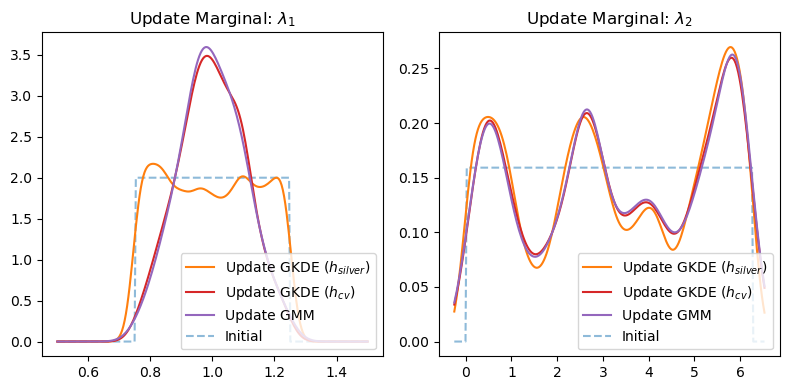

In [37]:
# plot check update distributions
ex_up1_fig, axes = plt.subplots(1,2)
ex_up1_fig.set_figwidth(4*2)
ex_up1_fig.set_figheight(4)

label_dict = {'sr':'Update GKDE $(h_{silver})$','cv':'Update GKDE $(h_{cv})$','gmm':'Update GMM'}
title_dict = {'r': '$\\lambda_1$','th':'$\\lambda_2$','c':'$(\\lambda_3,\\lambda_4)$'}
for j,item in enumerate(['sr','cv','gmm']):
    for i,(key,ax) in enumerate(zip(lam_dict.keys(),axes)):
        if key=='c':
            continue
            X,Y,XY_eval = lam_dict[key]
            this_kde = sps.gaussian_kde(init_sample[:,-2::].T,weights=r_dict[item])
            this_probs = this_kde.pdf(XY_eval.T).reshape(X.shape)
            ax.scatter(update_dict[item][:,-2],update_dict[item][:,-1],
                       alpha=0.45,label=label_dict[item],color=['C1','C3','C4'][j])
            if j==1:
                ax.contour(X,Y,this_probs)
        else:
#             ax.hist(update_dict[item][:,i],density=True,edgecolor='gray',alpha=0.2)
            this_x = lam_dict[key]
            this_kde = sps.gaussian_kde(init_sample[:,i],
                                        weights=r_dict[item],
                                        bw_method=h_sj_dict[key][item])
            ax.plot(this_x,this_kde.pdf(this_x),
                    label=label_dict[item],color=['C1','C3','C4'][j])
            if j==2:
                ax.plot(this_x,[init_dist.r_dist,init_dist.th_dist][i].pdf(this_x),color='C0',
                        zorder=-5,label='Initial',ls='--',alpha=0.5)
        if j==0:
            ax.set_title('Update Marginal: {}'.format(title_dict[key]))
for ax in axes:
    ax.set_ylim(ax.get_ylim()[0],ax.get_ylim()[1])
    ax.legend(loc='lower right')
ex_up1_fig.tight_layout()
name_kLmmd_UP1 = 'kLmmd_fig_UP1'
# ex_up1_fig.savefig(folder+name_kLmmd_UP1)

In [38]:
ax.get_ylim()

(-0.01347633320687507, 0.28300299734437645)

# Generate Updated Samples

Here we generate updated samples for the KDE and GMM in order to compare these in monte-carlo approximations of the KL-divergence or the IPM.

In [39]:
class dci_sk_dist:
    def __init__(self,init_dist,obs_dist,pred_dist,Q):
        self.Q = Q
        self.init_dist = init_dist
        self.obs_dist = obs_dist
        self.pred_dist = pred_dist
    
    def logpdf(self,lam):
        q = self.Q(lam)
        with np.errstate(divide='ignore', invalid='ignore'):        
            init_logpdf = self.init_dist.logpdf(lam)
            obs_logpdf = self.obs_dist.score_samples(q)
            pred_logpdf = self.pred_dist.score_samples(q)
            output = init_logpdf+obs_logpdf-pred_logpdf
        return output
    
    def pdf(self,lam):
        return np.exp(self.logpdf(lam))
    
    def accept_reject(self,lam_init,probs_return=False,random_state=None):
        # reproducibility
        if (random_state == None) or (type(random_state)==int):
            rng = np.random.default_rng(random_state)
        elif type(random_state)==np.random.Generator:
            rng = random_state
        else:
            raise ValueError ('random_state must be an integer or numpy.random.Generator object.')            

        # evaluate accept-reject algorithm
        # first get r value
        q = self.Q(lam_init)
        with np.errstate(divide='ignore', invalid='ignore'):
            obs = self.obs_dist.score_samples(q)
            pred = self.pred_dist.score_samples(q)
            this_logr = obs - pred
            this_r = np.exp(this_logr)
        # accept-reject
        M = np.max(this_r)
        t = rng.uniform(0,1,len(this_r))
        accept_reject = np.less_equal(t,this_r/M)
        
        if probs_return==True:
            up_prob = self.init_dist.logpdf(lam_init) + this_logr
            return lam_init[accept_reject], up_prob[accept_reject]
        else:
            return lam_init[accept_reject]

In [40]:
import timeit as timeit

In [41]:
# define the updates to compare: kde and GMM
update_wkde = dci_sk_dist(init_dist,obs_kde,pred_kde,Q)
update_wgmm = dci_sk_dist(init_dist,obs_GMM,pred_kde,Q)


In [42]:
load_samples = True
sample_fn = 'updatecirclemoons.npz'
if load_samples==True:
    update_load_samples = np.load(sample_fn) 
else:
#     print('Run following code block to generate samples.')
    raise ValueError('You need to run following code block to generate the samples.')

In [43]:
# run this cell to generate and save samples
if load_samples==False:
    # initial sample
    monte_rng = np.random.default_rng(90123412)
    n_monte = int(5e4) # change to 4 later.
    
    up_sample_dict = {key: {'sample':[],'logpdf':[],'other_logpdf':[]} for key in ['kde','gmm']}
    for ni in range(10):
        tick = timeit.default_timer()
        
        # get initial samples
        init4kde = init_dist.rvs(n_monte,random_state=monte_rng)
        init4gmm = init_dist.rvs(n_monte,random_state=monte_rng)
        
        # get update and logpdf values
        upkde_sample,prob_up_kde = update_wkde.accept_reject(init4kde,probs_return=True,random_state=monte_rng)
        upgmm_sample,prob_up_gmm = update_wgmm.accept_reject(init4gmm,probs_return=True,random_state=monte_rng)

        # save the values
        up_sample_dict['kde']['sample'].append(upkde_sample)
        up_sample_dict['kde']['logpdf'].append(prob_up_kde)
        up_sample_dict['gmm']['sample'].append(upgmm_sample)
        up_sample_dict['gmm']['logpdf'].append(prob_up_gmm)
        
        # get the evaluation of logpdf w.r.t. other distribution
        prob_gmm_wkdeup = update_wgmm.logpdf(upkde_sample)
        up_sample_dict['kde']['other_logpdf'].append(prob_gmm_wkdeup)
        prob_kde_wgmmup = update_wkde.logpdf(upgmm_sample)
        up_sample_dict['gmm']['other_logpdf'].append(prob_kde_wgmmup)
        
        tock = timeit.default_timer()
        print('Monte round {}: {} secs'.format(ni,tock-tick))
        print('\t Accepted {} kde, {} gmm.'.format(len(upkde_sample),len(upgmm_sample)))
        print()
    
    # post process
    for key in up_sample_dict.keys():
        for key_type in up_sample_dict[key].keys():
            up_sample_dict[key][key_type] = np.concatenate(up_sample_dict[key][key_type])
    # reformat dict for saving
    save_dict = {}
    for key in up_sample_dict.keys():
        for item in up_sample_dict[key].keys():
            if 'other' in item:
                save_dict[key+'W'+item] = up_sample_dict[key][item]
            else:
                save_dict[key+'_'+item] = up_sample_dict[key][item]
    # save the dictionary of numpy arrays
    np.savez(sample_fn,**save_dict)
    
    # load the dictionary of numpy arrays
    update_load_samples = np.load(sample_fn)

In [44]:
# check that update samples loaded
for key in update_load_samples.keys():
    print(key)

kde_sample
kde_logpdf
kdeWother_logpdf
gmm_sample
gmm_logpdf
gmmWother_logpdf


# Compute KL-divergence and MMD

Here we illustrate results from theory by computing KL-divergence and the IPM using MMD.

## Verification of KL-divergence

First, KL-divergence between update and initial is equal to KL between observed and predicted.

In [45]:
# log(up) - log(init) eval at update sample
kl_up_init = (update_load_samples['kde_logpdf'] - init_dist.logpdf(update_load_samples['kde_sample'])).mean()

# log(obs) - log(pred) eval at obs sample
this_n = len(update_load_samples['kde_sample']) # use same size n for fair comparison
obs_kde_resample = obs_kde.sample(this_n,random_state=sk_rand_seed) # fix random seed for reproducibility
kl_obs_pred = (obs_kde.score_samples(obs_kde_resample) - pred_kde.score_samples(obs_kde_resample)).mean()
print('Monte Carlo Sample n = {}'.format(this_n))
print('KL(up||init) = {}'.format(kl_up_init))
print('KL(obs||pred) = {}'.format(kl_obs_pred))

Monte Carlo Sample n = 26432
KL(up||init) = 1.5199668778342392
KL(obs||pred) = 1.5242515915919808


Next we compare the KL-divergence between updates using KDE and GMM vs. observeds using KDE and GMM.

In [46]:
# log(upkde) - log(upgmm) eval at update sample
kl_upkde_upgmm = (update_load_samples['kde_logpdf'] - update_load_samples['kdeWother_logpdf']).mean()

# log(obskde) - log(obsgmm) eval at obs sample
this_n = len(update_load_samples['kde_logpdf']) # use same size n for fair comparison
obs_kde_resample = obs_kde.sample(this_n,random_state=sk_rand_seed) # fix random seed for reproducibility
kl_obskde_obsgmm = (obs_kde.score_samples(obs_kde_resample) - obs_GMM.score_samples(obs_kde_resample)).mean()

print('Monte Carlo Sample n = {}'.format(this_n))
print('KL(upkde||upgmm) = {}'.format(kl_upkde_upgmm))
print('KL(obskde||obsgmm) = {}'.format(kl_obskde_obsgmm))

Monte Carlo Sample n = 26432
KL(upkde||upgmm) = 0.17481076237116608
KL(obskde||obsgmm) = 0.17868723878097867


In [47]:
# # convergence rate of monte-carlo scheme
# np.sqrt(1/(this_n))

In [48]:
print('Relative KL')
print('Updates: ', kl_upkde_upgmm/kl_up_init)
print('Observeds: ',kl_obskde_obsgmm/kl_obs_pred)

Relative KL
Updates:  0.11500958666957883
Observeds:  0.11722949135605072


## Verification of Pull-back IPM

For reference, we provide the approximate MC convergence rate of the estimator of the MMD.

In [49]:
# expected convergence rate of monte-carlo estimate of updates
n_monte_kde = len(update_load_samples['kde_sample'])
n_monte_gmm = len(update_load_samples['gmm_sample'])
print('MC Est. of IPM converges approx ',np.sqrt(1/n_monte_kde)+np.sqrt(1/n_monte_gmm))

MC Est. of IPM converges approx  0.012705864784187901


First, pb-IPM between update and initial is equal to pb-IPM between observed and predicted.

This allows us to compute a relative IPM, which is useful for comparing it to KL.

In [50]:
# evaluate the mmd between update and initial
mmd_upkde_init = my_mmd(Q(update_load_samples['kde_sample']),Q(init_dist.rvs(n_monte_kde,random_state=rng)))

# evaluate the mmd between observed and predicted distributions
obs_kde_resample = obs_kde.sample(n_monte_kde,random_state=sk_rand_seed) # fix random seed for reproducibility
pred_kde_resample = pred_kde.sample(n_monte_kde,random_state=sk_rand_seed+1) # fix random seed for reproducibility
mmd_obskde_pred = my_mmd(obs_kde_resample,pred_kde_resample)

print('Monte Carlo Sample n = {}'.format(n_monte_kde))
print('pb-MMD(up,init) = {}'.format(mmd_upkde_init))
print('pb-MMD(obs,pred) = {}'.format(mmd_obskde_pred))

Monte Carlo Sample n = 26432
pb-MMD(up,init) = 0.26286881141065843
pb-MMD(obs,pred) = 0.2620422237676257


Here we evaluate the pull-back IPM (using MMD) between the update using KDE and GMM.

In [ ]:
# evaluate pull-back mmd between updates
# compute Q(sampleA) and Q(sampleB) and mmd these push-forwards
mmd_upkde_upgmm = my_mmd(Q(update_load_samples['kde_sample']),Q(update_load_samples['gmm_sample']))
print('MC Estimate: (nkde,ngmm) = ({},{})'.format(n_monte_kde,n_monte_gmm))
print('pb-MMD(upkde,upgmm) = {}'.format(mmd_upkde_upgmm))

In [ ]:
# evaluate the mmd between observed distributions
obs_kde_resample = obs_kde.sample(n_monte_kde,random_state=sk_rand_seed) # fix random seed for reproducibility
obs_gmm_resample = obs_GMM.sample(n_monte_gmm)[0] # random seed already fixed for GMM
mmd_obskde_obsgmm = my_mmd(obs_kde_resample,obs_gmm_resample)
print('MC Estimate: (nkde,ngmm) = ({},{})'.format(n_monte_kde,n_monte_gmm))
print('MMD(obskde,obsgmm) = {}'.format(mmd_obskde_obsgmm))

In [ ]:
print('Relative pb-MMD')
print('Updates: ',mmd_upkde_upgmm/mmd_upkde_init)
print('Observeds: ',mmd_obskde_obsgmm/mmd_obskde_pred)